In [1]:
import gc
import time
import argparse
from fastai.layers import swish

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter

from fastai.callback.schedule import Learner
from fastai.data.core import DataLoaders
from fastai.losses import L1LossFlat
from fastai.callback.core import Callback
from fastai.callback.tracker import ReduceLROnPlateau, SaveModelCallback

from HW_torch import dataLoads_build, net_parameter_count, hw_layer
from HW_base import evaluate_build, focus_build

In [2]:
fname               = 'F5-E128-F60_Linear-Res_LSTM128x4-FC-SELU-FC'
epoch_num_first     = 100
batch_size_first    = 100
epoch_num_second    = 500
batch_size_second   = 1000
evaluate_num        = 128
focus_min           = 0.6

In [3]:
class net_test(torch.nn.Module):
    def __init__(self, evaluate_focus_list, **kwargs):
        super(net_test, self).__init__()
        self.hw_layer = hw_layer(evaluate_focus_list)
        self.embedding = torch.nn.Linear(self.hw_layer.channels, 128)

        self.lstm1 = torch.nn.LSTM(128, 128, num_layers=1, bias=False, bidirectional=True, batch_first=True)
        self.lstm2 = torch.nn.LSTM(128*3, 128, num_layers=1, bias=False, bidirectional=True, batch_first=True)
        self.lstm3 = torch.nn.LSTM(128*5, 128,  num_layers=1, bias=False, bidirectional=True, batch_first=True)
        self.lstm4 = torch.nn.LSTM(128*7, 128,  num_layers=1, bias=False, bidirectional=True, batch_first=True)

        self.fc1 = torch.nn.Linear(128*8, 32, bias=False)
        self.selu = torch.nn.SELU()
        self.fc2 = torch.nn.Linear(32, 1)

    def forward(self, x):
        x = self.hw_layer(x)
        x = self.embedding(x)

        x1, _ = self.lstm1(x)
        x = torch.concat((x, x1), dim=-1)

        x2, _ = self.lstm2(x)
        x = torch.concat((x, x2), dim=-1)

        x3, _ = self.lstm3(x)
        x = torch.concat((x, x3), dim=-1)

        x4, _ = self.lstm4(x)
        x = torch.concat((x1, x2, x3, x4), dim=-1)

        x = self.fc1(x)
        x = self.selu(x)
        x = self.fc2(x)
        return x

In [4]:
data_train_df = pd.read_csv('./Database/train.csv')
data_test_df = pd.read_csv('./Database/test.csv')

In [5]:
drop_columns = ['pressure','id', 'breath_id','one','count','breath_id_lag','breath_id_lag2','breath_id_lagsame','breath_id_lag2same','u_out_lag2']
x_columns = [col for col in data_train_df.columns if col not in drop_columns]
y_columns = ['pressure']

In [6]:
data_train = data_train_df[x_columns].values.astype(np.float32)
data_train = data_train.reshape(-1, 80, data_train.shape[-1])

target_train = data_train_df[y_columns].values.astype(np.float32)
target_train = target_train.reshape(-1, 80, target_train.shape[-1])

data_test = data_test_df[x_columns].values.astype(np.float32)
data_test = data_test.reshape(-1, 80, data_test.shape[-1])

In [7]:
np.random.seed(121212)
data_idx = np.arange(len(data_train))
np.random.shuffle(data_idx)

train_index = data_idx[:int(len(data_idx)*0.8)]
valid_index = data_idx[int(len(data_idx)*0.8):]

In [8]:
x_train, y_train = data_train[train_index], target_train[train_index]
x_valid, y_valid = data_train[valid_index], target_train[valid_index]
x_test = data_test

In [9]:
del data_train_df
del data_test_df
gc.collect()

0

In [10]:
evaluate_list = [evaluate_build(x_test[..., i], evaluate_num) for i in range(x_test.shape[-1])]
evaluate_focus_list = []
for evaluate in evaluate_list:
    focus = 1 - (len(evaluate) - 1)/10
    if focus < focus_min:
        focus = focus_min
    evaluate_focus = focus_build(evaluate, focus)
    evaluate_focus_list.append(evaluate_focus)

evaluate_num:   3,focus:0.8000: 3it [00:00, ?it/s]
evaluate_num:   3,focus:0.8000: 3it [00:00, ?it/s]
evaluate_num: 127,focus:0.6000: 127it [00:00, 320.74it/s]
evaluate_num:  99,focus:0.6000: 99it [00:00, 287.01it/s]
evaluate_num:   2,focus:0.9000: 2it [00:00, ?it/s]


In [11]:
model = net_test(evaluate_focus_list)
print(model)

train_parameter_num, freeze_parameter_num = net_parameter_count(model)
print(train_parameter_num, freeze_parameter_num)

net_test(
  (hw_layer): hw_layer(
    (evaluate_list): ModuleList(
      (0): Embedding(3, 1)
      (1): Embedding(3, 1)
      (2): Embedding(127, 1)
      (3): Embedding(99, 1)
      (4): Embedding(2, 1)
    )
    (focus_list): ModuleList(
      (0): Embedding(3, 1)
      (1): Embedding(3, 1)
      (2): Embedding(127, 1)
      (3): Embedding(99, 1)
      (4): Embedding(2, 1)
    )
  )
  (embedding): Linear(in_features=234, out_features=128, bias=True)
  (lstm1): LSTM(128, 128, bias=False, batch_first=True, bidirectional=True)
  (lstm2): LSTM(384, 128, bias=False, batch_first=True, bidirectional=True)
  (lstm3): LSTM(640, 128, bias=False, batch_first=True, bidirectional=True)
  (lstm4): LSTM(896, 128, bias=False, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=1024, out_features=32, bias=False)
  (selu): SELU()
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)
2684321 468


In [12]:
# state_dict = torch.load(f'models/{fname}_best.pth')
# model.load_state_dict(state_dict)

epoch,train_loss,valid_loss,time
0,1.777207,1.653373,00:22
1,1.125301,1.141084,00:22
2,1.006184,1.011639,00:21
3,0.957110,1.000026,00:22
4,0.860331,0.845309,00:22
5,0.783371,0.802786,00:22
6,0.676237,0.650932,00:22
7,0.610368,0.597129,00:22
8,0.583686,0.571858,00:22
9,0.558569,0.563829,00:22


Epoch 17: reducing lr to 0.00016517730602035383
Epoch 27: reducing lr to 0.00019921234762739878
Epoch 37: reducing lr to 0.00018554015972489495
Epoch 47: reducing lr to 0.0001570774813474464
Epoch 57: reducing lr to 0.00011874574116269403
Epoch 67: reducing lr to 7.717288981176588e-05
Epoch 77: reducing lr to 3.954721643898919e-05
Epoch 87: reducing lr to 1.2374550221471186e-05
Epoch 97: reducing lr to 3.532914522641744e-07


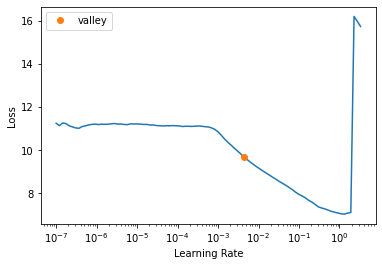

In [13]:
dataLoads = dataLoads_build(x_train, y_train, x_valid, y_valid, batch_size_first)
learn = Learner(dataLoads, model, loss_func=L1LossFlat())
learn.lr_find()
learn.fit_one_cycle(epoch_num_first, lr_max=2e-3, cbs=ReduceLROnPlateau(monitor='valid_loss', min_delta=0.5, patience=10))

In [14]:
model.state_dict

<bound method Module.state_dict of net_test(
  (hw_layer): hw_layer(
    (evaluate_list): ModuleList(
      (0): Embedding(3, 1)
      (1): Embedding(3, 1)
      (2): Embedding(127, 1)
      (3): Embedding(99, 1)
      (4): Embedding(2, 1)
    )
    (focus_list): ModuleList(
      (0): Embedding(3, 1)
      (1): Embedding(3, 1)
      (2): Embedding(127, 1)
      (3): Embedding(99, 1)
      (4): Embedding(2, 1)
    )
  )
  (embedding): Linear(in_features=234, out_features=128, bias=True)
  (lstm1): LSTM(128, 128, bias=False, batch_first=True, bidirectional=True)
  (lstm2): LSTM(384, 128, bias=False, batch_first=True, bidirectional=True)
  (lstm3): LSTM(640, 128, bias=False, batch_first=True, bidirectional=True)
  (lstm4): LSTM(896, 128, bias=False, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=1024, out_features=32, bias=False)
  (selu): SELU()
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)>

epoch,train_loss,valid_loss,time
0,0.120017,0.185505,00:14
1,0.119761,0.185495,00:13
2,0.119761,0.185522,00:14
3,0.119506,0.185453,00:14
4,0.119448,0.185488,00:13
5,0.119522,0.185492,00:13
6,0.119448,0.185494,00:14
7,0.119348,0.185482,00:14
8,0.119375,0.185489,00:14
9,0.119566,0.185481,00:14


Better model found at epoch 0 with valid_loss value: 0.18550541996955872.
Better model found at epoch 1 with valid_loss value: 0.18549488484859467.
Better model found at epoch 3 with valid_loss value: 0.18545258045196533.
Better model found at epoch 10 with valid_loss value: 0.1854318380355835.
Epoch 10: reducing lr to 1.163455541330712e-05
Epoch 20: reducing lr to 2.10434391208357e-05
Epoch 30: reducing lr to 3.566478840950393e-05
Epoch 40: reducing lr to 5.457989017079692e-05
Epoch 50: reducing lr to 7.660024335617453e-05
Epoch 60: reducing lr to 0.00010034221560051723
Epoch 70: reducing lr to 0.00012431401979568133
Epoch 80: reducing lr to 0.00014700943601841005
Epoch 90: reducing lr to 0.00016700239475079566
Epoch 100: reducing lr to 0.0001830366829573723
Epoch 110: reducing lr to 0.00019410481396064737
Epoch 120: reducing lr to 0.00019951132026669701
Epoch 130: reducing lr to 0.00019987438604138612
Epoch 140: reducing lr to 0.0001991048337440472
Epoch 150: reducing lr to 0.0001976

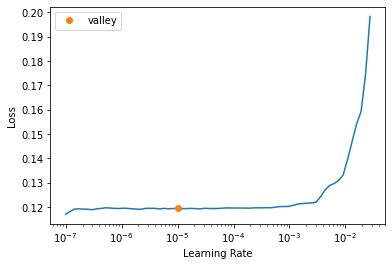

In [15]:
dataLoads = dataLoads_build(x_train, y_train, x_valid, y_valid, batch_size_second)
learn = Learner(dataLoads, model, loss_func=L1LossFlat())
learn.lr_find()
learn.fit_one_cycle(epoch_num_second, lr_max=2e-3, cbs=[ReduceLROnPlateau(monitor='valid_loss', min_delta=0.5, patience=10),
                                                        SaveModelCallback(monitor='valid_loss', fname=f'{fname}_best')])

In [16]:
from HW_torch import torch_valid, torch_predict

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

state_dict = torch.load(f'models/{fname}_best.pth')
model.load_state_dict(state_dict)

loss = torch_valid([model.to(device)], L1LossFlat(), (x_train, y_train),  batch_size_second, to_device=device)
valid_loss = torch_valid([model.to(device)], L1LossFlat(), (x_valid, y_valid),  batch_size_second, to_device=device)

print(loss, valid_loss)

0.11887024220873098 0.18434199132025242


In [17]:
predict = torch_predict([model.to(device)], x_test, batch_size_second, to_device=device)
predict = np.reshape(predict, (-1))

prodict: 100% 51/51 [00:03<00:00, 12.79it/s]


In [18]:
df = pd.read_csv('Database/sample_submission.csv', index_col=0)
df['pressure'] = predict

df.to_csv(f'Submission/{fname}.csv')

C:\users\ffly\appdata\local\programs\python\python39\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
